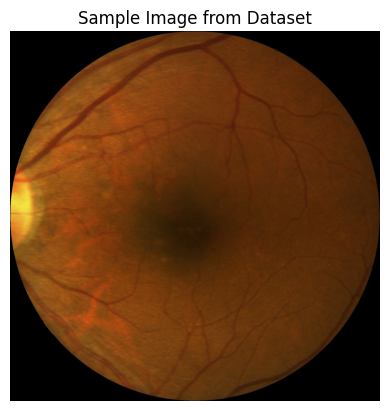

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
dataset_path="/content/drive/MyDrive/dataset/IMAGES"
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]

sample_img = cv2.imread(os.path.join(dataset_path, image_files[0]))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img)
plt.axis("off")
plt.title("Sample Image from Dataset")
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class UnlabeledImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image

dataset = UnlabeledImageDataset(dataset_path, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
images = next(iter(dataloader))
print(f"Batch Size: {images.shape}")

Batch Size: torch.Size([32, 3, 224, 224])


In [4]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img / 255.0
    return img

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

In [5]:
import torchvision.models as models
import torch.nn as nn
import numpy as np
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(1280, 2)  # Binary Classification (AMD vs Non-AMD)
model.to(device)
model.eval()

def auto_label_images(model, dataset_path):
    image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
    labels = {}

    for img_path in image_paths:
        img = preprocess_image(img_path)
        img = transform(img)
        img = img.unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(img)
            _, pred = torch.max(output, 1)
        label = "AMD" if pred.item() == 1 else "Non_AMD"
        labels[os.path.basename(img_path)] = label
    return labels

labels = auto_label_images(model, dataset_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


In [6]:
class AMD_Dataset(Dataset):
    def __init__(self, image_folder, labels_dict, transform=None):
        self.image_folder = image_folder
        self.labels_dict = labels_dict
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        label = 1 if self.labels_dict.get(img_name, "Non_AMD") == "AMD" else 0
        image = preprocess_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = AMD_Dataset(dataset_path, labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
from sklearn.model_selection import train_test_split

image_paths = list(labels.keys())
image_labels = [1 if labels[f] == "AMD" else 0 for f in image_paths]
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_imgs)}, Validation: {len(val_imgs)}, Test: {len(test_imgs)}")


Train: 556, Validation: 119, Test: 120


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def get_class_weights(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=np.array(all_labels)
    )
    return torch.tensor(class_weights, dtype=torch.float)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = (self.alpha[targets] * (1 - pt) ** self.gamma * BCE_loss).mean()
        return focal_loss

def train_model(model, train_loader, val_loader=None, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    class_weights = get_class_weights(train_loader).to(device)
    criterion = FocalLoss(alpha=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")
    return model

trained_model = train_model(model, dataloader, epochs=10)
torch.save(model.state_dict(), "efficientnetb0_amd1.pth")

Epoch 1: Loss=0.1951
Epoch 2: Loss=0.0976
Epoch 3: Loss=0.0844
Epoch 4: Loss=0.0832
Epoch 5: Loss=0.0387
Epoch 6: Loss=0.0435
Epoch 7: Loss=0.0606
Epoch 8: Loss=0.0459
Epoch 9: Loss=0.0701
Epoch 10: Loss=0.0307


In [ ]:
import torch.optim as optim

def train_model(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return model

trained_model = train_model(model, dataloader, epochs=10)


Epoch 1, Loss: 0.19834389142692088
Epoch 2, Loss: 0.15155052721500398
Epoch 3, Loss: 0.09732652209699154
Epoch 4, Loss: 0.0725845555216074
Epoch 5, Loss: 0.08666229566559196
Epoch 6, Loss: 0.04306459591723979
Epoch 7, Loss: 0.08663298968225717
Epoch 8, Loss: 0.06801469629630447
Epoch 9, Loss: 0.05327967706136406
Epoch 10, Loss: 0.037193446895107625


In [10]:
class AMD_Dataset(Dataset):
    def __init__(self, image_list, label_list, dataset_folder, transform=None):
        self.image_list = image_list
        self.label_list = label_list
        self.dataset_folder = dataset_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.dataset_folder, img_name)
        image = preprocess_image(img_path)
        label = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

test_dataset = AMD_Dataset(test_imgs, test_labels, dataset_path, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    predictions, ground_truths = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions, average='weighted')
    recall = recall_score(ground_truths, predictions, average='weighted')
    f1 = f1_score(ground_truths, predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return ground_truths, predictions

true_labels, predicted_labels = evaluate_model(trained_model, test_loader)

Accuracy: 0.9333
Precision: 0.9647
Recall: 0.9333
F1-Score: 0.9423


In [ ]:
print(f"Test set size: {len(test_loader.dataset)}")


Test set size: 120


In [ ]:
from random import sample

sample_indices = sample(range(len(true_labels)), min(5, len(true_labels)))
for i in sample_indices:
    print(f"Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}")


Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


In [ ]:
from random import sample

sample_indices = sample(range(len(true_labels)), min(10, len(true_labels)))
for i in sample_indices:
    pred = predicted_labels[i]
    actual = true_labels[i]
    print(f"[{i}] Predicted: {'AMD' if pred == 1 else 'Non-AMD'}, Actual: {'AMD' if actual == 1 else 'Non-AMD'}")


[17] Predicted: Non-AMD, Actual: Non-AMD
[115] Predicted: Non-AMD, Actual: Non-AMD
[31] Predicted: AMD, Actual: AMD
[74] Predicted: AMD, Actual: AMD
[77] Predicted: AMD, Actual: AMD
[101] Predicted: Non-AMD, Actual: Non-AMD
[8] Predicted: AMD, Actual: AMD
[65] Predicted: Non-AMD, Actual: Non-AMD
[107] Predicted: AMD, Actual: AMD
[21] Predicted: AMD, Actual: AMD


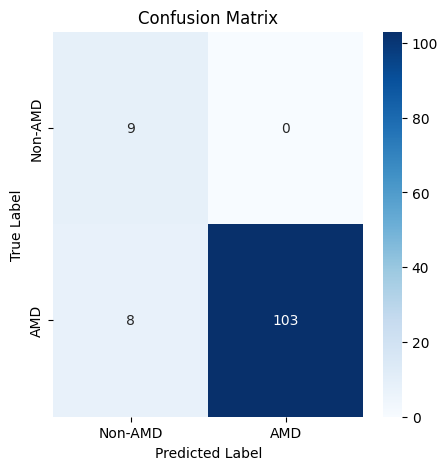

In [12]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names=["Non-AMD", "AMD"]):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels)


In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=77ff1a674a4a81843f6b6a4715d031b6fbab9f32a6d77910d90df5c44dec78ba
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available! Using:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected! Running on CPU.")


⚠️ No GPU detected! Running on CPU.


In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!apt-get install -y nvidia-driver-525
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-12 dctrl-tools dkms fakeroot gcc-12 keyboard-configuration libasan8 libfakeroot libfontenc1
  libgail-common libgail18 libgcc-12-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libjansson4
  liblocale-gettext-perl libnvidia-cfg1-525 libnvidia-common-525 libnvidia-compute-525
  libnvidia-decode-525 libnvidia-encode-525 libnvidia-extra-525 libnvidia-fbc1-525 libnvidia-gl-525
  librsvg2-common libtsan2 libxcvt0 libxfont2 libxkbfile1 nvidia-compute-utils-525 nvidia-dkms-525
  nvidia-kernel-common-525 nvidia-kernel-source-525 nvidia-prime nvidia-settings nvidia-utils-525
  python3-xkit screen-resolution-extra systemd-hwe-hwdb udev x11-xkb-utils xcvt xfonts-base
  xfonts-encodings xfonts-utils xserver-common xserver-xorg-core xserver-xorg-video-nvidia-525
Suggested packages:
  gcc-12-locales cpp-12-doc debtags menu gcc-12-multilib gcc-12-d

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

trained_model.to(device)


✅ Using device: cpu


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git



  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-e1_0i98s
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-e1_0i98s
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 864.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 872.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/

  0%|          | 0/3000 [00:00<?, ?it/s]

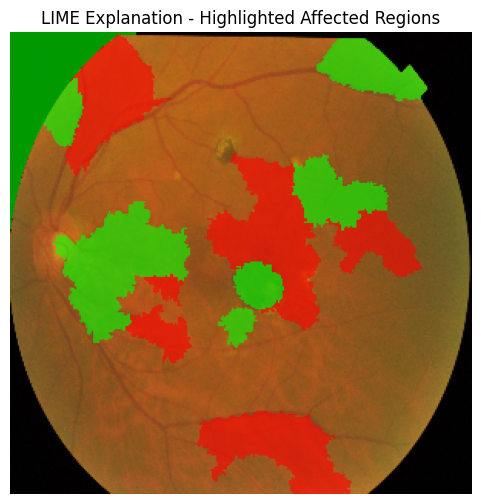

In [ ]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from skimage.segmentation import slic
import lime
import lime.lime_image
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open("/content/drive/MyDrive/dataset/IMAGES/0_1kIM_10_ARMD.png")  # Adjust filename
image = np.array(image)
def preprocess_image(image):
    """Convert PIL Image or PyTorch Tensor to uint8 NumPy array for visualization."""
    if isinstance(image, Image.Image):  # If it's a PIL image, convert to NumPy
        image = np.array(image)

    if isinstance(image, torch.Tensor):  # If it's a tensor, convert to NumPy
        image = image.permute(1, 2, 0).cpu().numpy()

    # Normalize if needed
    if image.max() <= 1.0:
        image = image * 255

    return image.astype(np.uint8)

# Preprocess image
image_uint8 = preprocess_image(image)

def model_predict(images):
    """ Convert input images to tensor and pass through model """
    images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0
    with torch.no_grad():
        preds = model(images)
    return preds.numpy()

# Initialize LIME explainer
explainer = lime.lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_uint8,
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=3000
)

# Generate mask highlighting important areas
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=15,   # Increase features for more highlighted areas
    min_weight=0.01    # Lower threshold to capture subtle affected regions
)

# Create a copy of the original image for overlay
highlighted_image = image_uint8.copy()

# Apply color highlighting
highlighted_image[mask == 1] = [0, 255, 0]   # Green - positive influence (AMD regions)
highlighted_image[mask == -1] = [255, 0, 0]  # Red - negative influence (non-AMD regions)

# Blend the highlighted regions with the original image for smooth visualization
alpha = 0.4  # Reduce blending strength for better contrast
blended = cv2.addWeighted(image_uint8, alpha, highlighted_image, 1 - alpha, 0)

# Display final visualization
plt.figure(figsize=(6, 6))
plt.imshow(blended)
plt.title("LIME Explanation - Highlighted Affected Regions")
plt.axis("off")
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

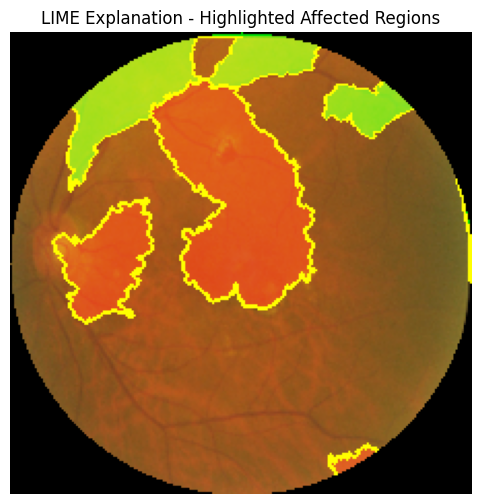

✅ LIME visualization complete!


In [16]:
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from torchvision import models
import cv2

# ✅ Load your EfficientNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(1280, 2)
model = model.to(device)
model.eval()

# ✅ Image preprocessing
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image_np = np.array(image)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)
    return image_np, input_tensor

# ✅ Circular mask function to crop outside the eye
def apply_circular_mask(image: np.ndarray):
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])
    cv2.circle(mask, center, radius, 255, -1)
    if len(image.shape) == 3 and image.shape[2] == 3:
        mask = cv2.merge([mask, mask, mask])
    return cv2.bitwise_and(image, mask)

# ✅ Define prediction function for LIME
def batch_predict(images):
    model.eval()
    batch = torch.stack([
        transforms.ToTensor()(Image.fromarray(img)).float() for img in images
    ])
    batch = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])(batch)
    batch = batch.to(device)
    with torch.no_grad():
        logits = model(batch)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

def run_lime(image_path):
    image_np, input_tensor = preprocess_image(image_path)

    # Initialize LIME
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Generate LIME heatmap (like original)
    lime_img, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    # Convert to uint8 and apply circular mask AFTER mark_boundaries
    heatmap = mark_boundaries(lime_img, mask)
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    heatmap_uint8 = apply_circular_mask(heatmap_uint8)

    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap_uint8)
    plt.axis("off")
    plt.title("LIME Explanation - Highlighted Affected Regions")
    plt.show()

    print("✅ LIME visualization complete!")

run_lime("/content/drive/MyDrive/dataset/IMAGES/0_1kIM_10_ARMD.png")

  0%|          | 0/3000 [00:00<?, ?it/s]

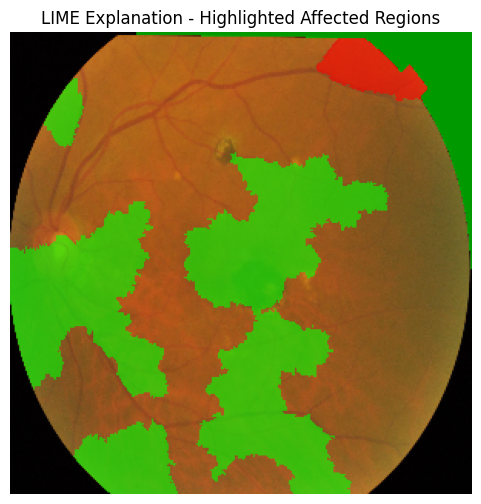

In [15]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from skimage.segmentation import slic
import lime
import lime.lime_image
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open("/content/drive/MyDrive/dataset/IMAGES/0_1kIM_10_ARMD.png")  # Adjust filename
image = np.array(image)
def preprocess_image(image):
    """Convert PIL Image or PyTorch Tensor to uint8 NumPy array for visualization."""
    if isinstance(image, Image.Image):  # If it's a PIL image, convert to NumPy
        image = np.array(image)

    if isinstance(image, torch.Tensor):  # If it's a tensor, convert to NumPy
        image = image.permute(1, 2, 0).cpu().numpy()

    # Normalize if needed
    if image.max() <= 1.0:
        image = image * 255

    return image.astype(np.uint8)

# Preprocess image
image_uint8 = preprocess_image(image)

def model_predict(images):
    """ Convert input images to tensor and pass through model """
    images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0
    with torch.no_grad():
        preds = model(images)
    return preds.numpy()

# Initialize LIME explainer
explainer = lime.lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_uint8,
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=3000
)

# Generate mask highlighting important areas
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=15,   # Increase features for more highlighted areas
    min_weight=0.01    # Lower threshold to capture subtle affected regions
)

# Create a copy of the original image for overlay
highlighted_image = image_uint8.copy()

# Apply color highlighting
highlighted_image[mask == 1] = [0, 255, 0]   # Green - positive influence (AMD regions)
highlighted_image[mask == -1] = [255, 0, 0]  # Red - negative influence (non-AMD regions)

# Blend the highlighted regions with the original image for smooth visualization
alpha = 0.4  # Reduce blending strength for better contrast
blended = cv2.addWeighted(image_uint8, alpha, highlighted_image, 1 - alpha, 0)

# Display final visualization
plt.figure(figsize=(6, 6))
plt.imshow(blended)
plt.title("LIME Explanation - Highlighted Affected Regions")
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


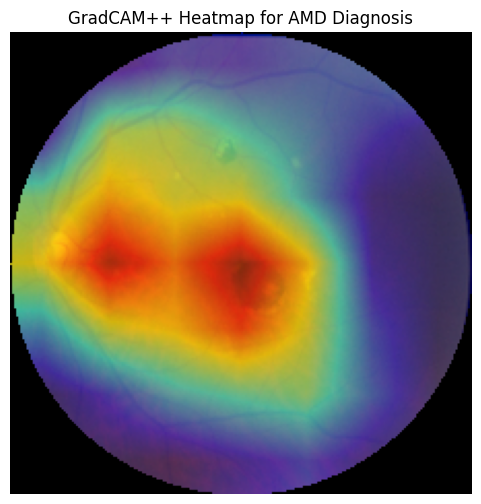

✅ GradCAM++ visualization complete!


In [17]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# ✅ Load Pretrained EfficientNet-B0 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True).to(device)
model.classifier[1] = torch.nn.Linear(1280, 2)  # Modify classifier for AMD classification
model.eval()

# ✅ Image Preprocessing Function (Fix: Ensure Consistent 224x224 Size)
def preprocess_img(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Ensure correct input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize((224, 224))  # 🔥 Fix: Ensure original image matches model input size
    image_np = np.array(image_resized) / 255.0  # Convert to NumPy and normalize
    tensor_img = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return tensor_img, image_np

# ✅ Circular Crop Mask Function
def crop_circle(image):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    masked = cv2.bitwise_and(image, image, mask=mask)
    return masked

# ✅ Load & Preprocess Image
image_path = "/content/drive/MyDrive/dataset/IMAGES/0_1kIM_10_ARMD.png"  # 🔴 Change this to your actual image file
input_tensor, image_np = preprocess_img(image_path)

# ✅ Define Target Layer for GradCAM++
target_layers = [model.features[-1]]  # Last convolutional layer

# ✅ Initialize GradCAM++
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# ✅ Generate Heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0]  # Get GradCAM++ heatmap

# ✅ Overlay Heatmap on Original Image (Fix: Ensure 224x224 consistency)
visualization = show_cam_on_image(image_np.astype(np.float32), cv2.resize(grayscale_cam, (224, 224)), use_rgb=True)

# ✅ Apply Circular Crop to Remove Outer Artifacts
visualization_cropped = crop_circle(visualization)

# ✅ Plot the Final Output
plt.figure(figsize=(6, 6))
plt.imshow(visualization_cropped)
plt.axis("off")
plt.title("GradCAM++ Heatmap for AMD Diagnosis")
plt.show()

print("✅ GradCAM++ visualization complete!")


In [19]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.8 MB/s eta 0:00:00


In [24]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (in memory)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(1280, 2)
model.to(device)
model.eval()  # very important!

# 🔽 Define preprocessing (same as training time)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 🔽 Load and preprocess the test image
image_path = "/content/midtown_vision_digital_retinal_imaging.jpg"  # <-- Your uploaded image path
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Predict
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    label = "AMD" if predicted.item() == 1 else "Non-AMD"

print("Predicted label:", label)

Predicted label: Non-AMD


Prediction: AMD
Probabilities: [0.49776047 0.5022396 ]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


  0%|          | 0/1000 [00:00<?, ?it/s]

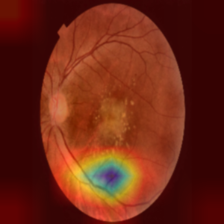

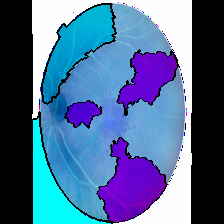

In [36]:
import torch
import torch.nn.functional as F
from torchvision import models
import numpy as np
import cv2
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

# Load Model
model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(torch.load('/content/efficientnetb0_amd1.pth', map_location=torch.device('cpu')))
model.eval()

# Preprocessing Function
def preprocess_image(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
    img = (img - 0.5) / 0.5
    return img.unsqueeze(0)

# Grad-CAM++
def grad_cam_plus(model, input_tensor, target_class):
    gradients, activations = [], []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activation(module, input, output):
        activations.append(output)

    target_layer = model.features[-1]
    hook_a = target_layer.register_forward_hook(save_activation)
    hook_g = target_layer.register_backward_hook(save_gradient)

    output = model(input_tensor)
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    grads = gradients[0]
    acts = activations[0]
    weights = torch.mean(grads, dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * acts, dim=1).squeeze()
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = ((img * 0.5) + 0.5) * 255
    img = img.astype(np.uint8)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    hook_a.remove()
    hook_g.remove()
    return overlay

def classifier_fn(images):
    model.eval()
    images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0  # [N, H, W, C] -> [N, C, H, W]
    images = (images - 0.5) / 0.5  # Normalize
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()

# LIME
def lime_explanation(original_image, model):
    """
    Generates a LIME explanation image for a fundus image and a given model.

    Args:
        original_image: PIL Image
        model: PyTorch model

    Returns:
        lime_img: RGB NumPy image (uint8), with green/red overlays
    """
    # Convert PIL image to NumPy and resize for LIME
    img_np = np.array(original_image.resize((224, 224)))

    # Define prediction function for LIME (expects [B, H, W, C] with values in [0,1])
    def batch_predict(images):
        images = torch.tensor(images.transpose((0, 3, 1, 2))).float()
        images = (images - 0.5) / 0.5  # Normalize like training
        with torch.no_grad():
            preds = model(images.to(next(model.parameters()).device))
            return torch.softmax(preds, dim=1).cpu().numpy()

    # LIME explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Get mask for the top predicted class
    pred_class = explanation.top_labels[0]
    lime_img, mask = explanation.get_image_and_mask(
        label=pred_class,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # Overlay boundaries with color-coded segments
    result = mark_boundaries(lime_img, mask, color=(1, 1, 0))  # Yellow boundary
    result = (result * 255).astype(np.uint8)

    return result

# UI Function
def predict_and_visualize(change):
    clear_output(wait=True)
    # Get uploaded image data
    uploaded_file = next(iter(upload_btn.value.values()))
    content = uploaded_file['content']

    # Read image from bytes
    img = Image.open(io.BytesIO(content)).convert('RGB')
    input_tensor = preprocess_image(img)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).numpy()[0]
        pred = np.argmax(probs)
        label = "AMD" if pred == 1 else "Non-AMD"

    print(f"Prediction: {label}")
    print(f"Probabilities: {probs}")

    if pred == 1:
        cam = grad_cam_plus(model, input_tensor, pred)
        lime_result = lime_explanation(img, model)
        display(Image.fromarray(cam))
        display(Image.fromarray((lime_result * 255).astype(np.uint8)))
    else:
        print("LIME and Grad-CAM++ are not shown for Non-AMD.")


# File Upload Widget
upload_btn = widgets.FileUpload(accept='image/*', multiple=False)
upload_btn.observe(lambda change: predict_and_visualize(upload_btn), names='value')

display(widgets.HTML("<h2>Upload Fundus Image</h2>"))
display(upload_btn)
